# **5min stock data**

In this notebook we will explore a basic pipeline for 5min interval stock data. We will be working with a portfolio of highly correlated stocks: AAPL, GOOG, QCOM, and TSLA. We will train our models using the Balanced Focal Loss function and compare it to our previous performan using Categorical Cross Entropy Loss. These stocks were highly correlated around Aug - Oct 2022. The stock dataset contains timestamps, prices and trading volume, but does not contin any target variables.
- Timestamps &#8594; Interval
- Open/Close/High/Low Prices &#8594; Ratio
- Trading Volume &#8594; Ratio

To use the timestamps we will sinusoidally encode them. We will also add engineered features such as the price difference.

 We will create the target variable by taking the midpoint of Open/Close prices for M future days and then averaging these values. This target variable is Oridnal and has 3 possible classes: 
- 0 - downward price movement
- 1 - no change
- 2 - upward price movement

The price movements are derived by a threshold that is defined using the IQR method to detect outliers. Currently we use a limit of 1, and every Q1 outlier is classified as "0 - downward price movement", every Q3 outlier is classified as "2 - upward price movement", and all inliers are classified as: "1 - no change".

#### NOTE:
This dataset has discontinuities after each trading day (i.e. from final afterhours trade until the first afterhours trade the next day). It is possible that other afterhours activities could have occured to impact the prices during this time period. 

## Models

The main model we will be testing in this notebook is a Transformer Encoder. Typically a Transformer has an Encoder and Decoder portion, where the Encoder learns information about which parts of the input sequence are relevant to eachother. The Decoder does the opposite, it takes the continuouss representation learned by the Encoder and learns to generate an ordered output sequence. For the Time Series Classifiecation problem it is unecessary to include the Decoder, we can simply use the Encoder to learn relative correlations of the inputs and add a Vanilla Feed Forward Neural Network to the end of the Encoder Blocks to obtain the desired classification. [Source](https://userweb.cs.txstate.edu/~amk181/AIME_LSTM_Attention_vs_Transformer.pdf).

The Transformer Encoder also relies on positional encoding in order to implement this, we will first project the input vectors into high dimensional space as done [here](https://arxiv.org/pdf/2010.02803.pdf), and then add the positional Encoding as done in the [original paper](https://arxiv.org/pdf/1706.03762.pdf).


In order to compare how effective the Transformer is in modeling seuqential data, we will compare its results to:
- Baseline Model (uses previous predictions)
- Linear Model
- Neural Network
- LSTM

### Library Import

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

### Local Imports

Get base dir for imports, this allows us to look in the main algotrading folder to import local modules

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.path.abspath('..'), '..'))
sys.path.append(BASE_DIR)

In [3]:
from data_utils import *
from data_pipeline import *
from window_generator import WindowGenerator
from models.basic_transformer import TransformerModel

### Ensure that GPU is available

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Get the Data

Load data for sequntial models

In [5]:
X_train = np.load('../../data/transformed/5min/train_data.npy')
y_train = np.load('../../data/transformed/5min/train_targets.npy')
X_test = np.load('../../data/transformed/5min/test_data.npy')
y_test = np.load('../../data/transformed/5min/test_targets.npy')


Get data for single instance models (baseline neural network)

In [6]:
X_train_single = X_train[:, -1, :]
y_train_single = y_train[:, -1]
X_test_single = X_test[:, -1, :]
y_test_single = y_test[:, -1]

### Start Training Models

First we will get baseline predictions

In [7]:
from sklearn.metrics import accuracy_score, matthews_corrcoef

base_train_acc = accuracy_score(y_train_single[1:],  # targets
                                y_train_single[:-1]) # baseline predictions

base_test_acc = accuracy_score(y_test_single[1:],  # targets
                               y_test_single[:-1]) # baseline predictions

In [8]:
base_train_mcc = matthews_corrcoef(y_train_single[1:],  # targets
                                   y_train_single[:-1]) # baseline predictions

base_test_mcc = matthews_corrcoef(y_test_single[1:],  # targets
                                  y_test_single[:-1]) # baseline predictions

In [9]:
print('Baseline Train Accuracy: ', base_train_acc)
print('Baseline Test Accuracy: ', base_test_acc)

print('Baseline Train MCC: ', base_train_mcc)
print('Baseline Test MCC: ', base_test_mcc)

Baseline Train Accuracy:  0.6274800629156434
Baseline Test Accuracy:  0.560739090551697
Baseline Train MCC:  0.3209280867640351
Baseline Test MCC:  0.26098550930297915


### Train Linear Model
Now let's train a linear model and check is's performance

In [13]:
linear = tf.keras.Sequential([
        layers.Dense(units=3, activation='softmax')
    ])

In [ ]:
linear.compile(
        # loss=SparseCategoricalFocalLoss(gamma=2, class_weight=weights),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.5),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), mcc_metric],
        )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='min')

linear_history = linear.fit(X_train_single, y_train_single, 
                     validation_data=(X_test_single, y_test_single),
                     callbacks=[early_stopping],
                     epochs=30, batch_size=32)

In [18]:
# save model
linear.save('models/basic_linear_model_2', include_optimizer=True)

INFO:tensorflow:Assets written to: models/basic_linear_model_2\assets


In [17]:
linear_history.history['val_mcc_metric']

[0.2108549326658249,
 0.2530534267425537,
 0.27885469794273376,
 0.3187476694583893,
 0.34177064895629883,
 0.31531521677970886,
 0.28902533650398254,
 0.2920178472995758,
 0.222690150141716,
 0.3110833466053009,
 0.30168870091438293,
 0.3035198450088501,
 0.25144749879837036,
 0.3494548499584198,
 0.232704758644104,
 0.1809820532798767,
 0.26304954290390015,
 0.28565964102745056,
 0.3297762870788574]

### Train and test the Transformer Model

In [66]:
'''
   contains the basic Transformer Encoder Architecture
   usage:
   
   from basic_transformer import TransformerModel

   transformer_model = TransformerModel(
            n_heads=2,
            d_model=512,
            ff_dim=256,
            num_transformer_blocks=2,
            mlp_units=[256],
            n_outputs=3,
            dropout=0.1,
            mlp_dropout=0.1)


   Position Encoding Code from: https://www.tensorflow.org/text/tutorials/transformer.
'''


import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow_addons.layers import MultiHeadAttention



# ============================================================================
# Positional Encoding
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(layers.Layer):
    def __init__(self, d_model, ff_dim):
        super().__init__()
        self.d_model = d_model
        self.ff_dim = ff_dim

    def build(self, input_shape):
        # self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.embedding = layers.Dense(self.d_model)
        self.pos_encoding = positional_encoding(length=self.ff_dim, depth=self.d_model)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

# ============================================================================
# Transformer Encoder

class TransformerEncoder(tf.keras.layers.Layer):

    def __init__(self, n_heads, d_model, ff_dim, dropout=0):
        super().__init__()
        
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_dim = ff_dim
        self.dropout = dropout

        self.attn_heads = list()


    def build(self, input_shape):
        
        # attention portion
        self.attn_multi = MultiHeadAttention(num_heads=self.n_heads, 
                                             head_size=self.d_model, 
                                             dropout=self.dropout)
        self.attn_dropout = layers.Dropout(self.dropout)
        self.attn_norm = layers.LayerNormalization(epsilon=1e-6)

        # feedforward portion
        self.ff_conv1 = layers.Conv1D(filters=self.ff_dim, 
                                      kernel_size=1, 
                                      activation='relu')
        self.ff_dropout = layers.Dropout(self.dropout)
        self.ff_conv2 = layers.Conv1D(filters=input_shape[-1],
                                      kernel_size=1)
        self.ff_norm = layers.LayerNormalization(epsilon=1e-6)


    def call(self, inputs):
        # attention portion
        x = self.attn_multi([inputs, inputs])
        x = self.attn_dropout(x)
        x = self.attn_norm(x)

        # get first residual
        res = x + inputs
        
        # feedforward portion
        x = self.ff_conv1(res)
        x = self.ff_dropout(x)
        x = self.ff_conv2(x)
        x = self.ff_norm(x)
        
        # return residual
        return res + x

# ============================================================================
# Transformer Model main

class TransformerModel(keras.Model):

    def __init__(self, 
            n_heads,
            d_model,
            # d_head, # set same value for d_k and d_v
            ff_dim,
            num_transformer_blocks,
            mlp_units,
            n_outputs=3,
            dropout=0.1,
            mlp_dropout=0.1):
            
        super().__init__()
        
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_dim = ff_dim
        self.num_transformer_blocks = num_transformer_blocks
        self.mlp_units = mlp_units
        self.n_outputs = n_outputs
        self.dropout = dropout
        self.mlp_dropout = mlp_dropout
        
         
    def build(self, input_shape):

        # get embedding layer that projects inputs inot high dimensional space
        # self.embed = layers.Dense(self.d_model)

        # get learnable time layer
        # self.time_layer = layers.Layer(tf.random.uniform((input_shape[1], self.d_model), -0.2, 0.2))
        # self.time_layer = tf.Variable(
        #     initial_value=tf.random.uniform((input_shape[1], self.d_model), -0.2, 0.2)
        #     )
        
        # get positional embedding
        self.positional_embedding = PositionalEmbedding(self.d_model, self.ff_dim)

        # get transformer encoders
        self.encoders = [TransformerEncoder(self.n_heads, self.d_model, self.ff_dim, self.dropout) 
                         for _ in range(self.num_transformer_blocks)]

        self.avg_pool = layers.GlobalAveragePooling1D(data_format='channels_last') # batch, steps, features "channels_first")

        # get MLP portion of network
        self.mlp_layers = []
        for dim in self.mlp_units:
            self.mlp_layers.append(layers.Dense(dim, activation="relu"))
            self.mlp_layers.append(layers.Dropout(self.mlp_dropout))

        # output layer 
        self.mlp_output = layers.Dense(self.n_outputs, activation='softmax')


    def call(self, x):

        # project input data into high dimensional space
        # x = self.embed(x)

        # inject time information ??
        # x = x + self.time_layer(x)

        # Project Input to high Dimensional Space and Encode Position Information
        x = self.positional_embedding(x)

        
        # Encoder Portion
        for encoder in self.encoders:
            x = encoder(x)

        # Average Pooling
        x = self.avg_pool(x)

        # MLP portion for classification
        for mlp_layer in self.mlp_layers:
            x = mlp_layer(x)

        x = self.mlp_output(x)

        return x

    # Needed for saving and loading model with custom layer
    # see: https://www.tensorflow.org/guide/keras/save_and_serialize
    def get_config(self): 
        config = super().get_config().copy()
        config.update({
                'n_heads' : self.n_heads,
                'd_model' : self.d_model,
                'ff_dim' : self.ff_dim,
                'num_transformer_blocks' : self.num_transformer_blocks,
                'mlp_units' : self.mlp_units,
                'n_outputs' : self.n_outputs,
                'dropout' : self.dropout,
                'mlp_dropout' : self.mlp_dropout})
        return config    

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    

In [67]:
transformer_model = TransformerModel(
                                    n_heads=2,
                                    d_model=256,
                                    ff_dim=256,
                                    num_transformer_blocks=1,
                                    mlp_units=[256],
                                    n_outputs=3,
                                    dropout=0.3,
                                    mlp_dropout=0.3)

In [68]:
def lr_scheduler(epoch, lr, warmup_epochs=15, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [69]:
transformer_model.compile(
        # loss=SparseCategoricalFocalLoss(gamma=2, class_weight=weights),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), mcc_metric],
        )

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='models/transformer_checkpoint',
        save_weights_only=False,
        monitor='val_mcc_metric',
        mode='max',
        save_best_only=True)

        
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

xformer_history = transformer_model.fit(X_train, y_train_single, 
                     validation_data=(X_test, y_test_single),
                     epochs=100, batch_size=32,
                     callbacks=[lr_callback, early_stopping, model_checkpoint_callback]
                     )

Epoch 1/100
4530/4530 [==============================] - ETA: 0s - loss: 1.7501 - sparse_categorical_accuracy: 0.4852 - mcc_metric: 0.0472

INFO:tensorflow:Assets written to: models\transformer_checkpoint\assets


INFO:tensorflow:Assets written to: models\transformer_checkpoint\assets


4530/4530 [==============================] - 61s 13ms/step - loss: 1.7501 - sparse_categorical_accuracy: 0.4852 - mcc_metric: 0.0472 - val_loss: 1.2030 - val_sparse_categorical_accuracy: 0.5380 - val_mcc_metric: -0.0031 - lr: 1.0000e-06
Epoch 2/100
4529/4530 [============================>.] - ETA: 0s - loss: 0.9325 - sparse_categorical_accuracy: 0.6044 - mcc_metric: 0.0672

INFO:tensorflow:Assets written to: models\transformer_checkpoint\assets


INFO:tensorflow:Assets written to: models\transformer_checkpoint\assets


4530/4530 [==============================] - 59s 13ms/step - loss: 0.9326 - sparse_categorical_accuracy: 0.6044 - mcc_metric: 0.0672 - val_loss: 1.0227 - val_sparse_categorical_accuracy: 0.5577 - val_mcc_metric: 0.0394 - lr: 6.7600e-05
Epoch 3/100
4530/4530 [==============================] - 57s 13ms/step - loss: 0.8903 - sparse_categorical_accuracy: 0.6139 - mcc_metric: 0.0711 - val_loss: 1.0223 - val_sparse_categorical_accuracy: 0.5542 - val_mcc_metric: 0.0226 - lr: 1.3420e-04
Epoch 4/100
4530/4530 [==============================] - 57s 13ms/step - loss: 0.8816 - sparse_categorical_accuracy: 0.6154 - mcc_metric: 0.0729 - val_loss: 1.0088 - val_sparse_categorical_accuracy: 0.5423 - val_mcc_metric: 0.0266 - lr: 2.0080e-04
Epoch 5/100
4530/4530 [==============================] - ETA: 0s - loss: 0.8785 - sparse_categorical_accuracy: 0.6159 - mcc_metric: 0.0822

INFO:tensorflow:Assets written to: models\transformer_checkpoint\assets


INFO:tensorflow:Assets written to: models\transformer_checkpoint\assets


4530/4530 [==============================] - 58s 13ms/step - loss: 0.8785 - sparse_categorical_accuracy: 0.6159 - mcc_metric: 0.0822 - val_loss: 1.0529 - val_sparse_categorical_accuracy: 0.5596 - val_mcc_metric: 0.0638 - lr: 2.6740e-04
Epoch 6/100
4530/4530 [==============================] - ETA: 0s - loss: 0.8148 - sparse_categorical_accuracy: 0.6456 - mcc_metric: 0.2264

INFO:tensorflow:Assets written to: models\transformer_checkpoint\assets


INFO:tensorflow:Assets written to: models\transformer_checkpoint\assets


4530/4530 [==============================] - 60s 13ms/step - loss: 0.8148 - sparse_categorical_accuracy: 0.6456 - mcc_metric: 0.2264 - val_loss: 0.7993 - val_sparse_categorical_accuracy: 0.6562 - val_mcc_metric: 0.3580 - lr: 3.3400e-04
Epoch 7/100
4530/4530 [==============================] - 61s 13ms/step - loss: 0.7292 - sparse_categorical_accuracy: 0.6893 - mcc_metric: 0.3757 - val_loss: 0.8355 - val_sparse_categorical_accuracy: 0.6496 - val_mcc_metric: 0.3261 - lr: 4.0060e-04
Epoch 8/100
4530/4530 [==============================] - 58s 13ms/step - loss: 0.7227 - sparse_categorical_accuracy: 0.6916 - mcc_metric: 0.3797 - val_loss: 0.8286 - val_sparse_categorical_accuracy: 0.6537 - val_mcc_metric: 0.3292 - lr: 4.6720e-04
Epoch 9/100
4530/4530 [==============================] - 58s 13ms/step - loss: 0.7174 - sparse_categorical_accuracy: 0.6935 - mcc_metric: 0.3839 - val_loss: 1.0110 - val_sparse_categorical_accuracy: 0.6298 - val_mcc_metric: 0.2569 - lr: 5.3380e-04
Epoch 10/100
4528/45

INFO:tensorflow:Assets written to: models\transformer_checkpoint\assets


INFO:tensorflow:Assets written to: models\transformer_checkpoint\assets


4530/4530 [==============================] - 59s 13ms/step - loss: 0.7154 - sparse_categorical_accuracy: 0.6944 - mcc_metric: 0.3864 - val_loss: 0.7832 - val_sparse_categorical_accuracy: 0.6625 - val_mcc_metric: 0.3707 - lr: 6.0040e-04
Epoch 11/100
4530/4530 [==============================] - 58s 13ms/step - loss: 0.7147 - sparse_categorical_accuracy: 0.6932 - mcc_metric: 0.3848 - val_loss: 0.9209 - val_sparse_categorical_accuracy: 0.6367 - val_mcc_metric: 0.3080 - lr: 6.6700e-04
Epoch 12/100
4530/4530 [==============================] - 58s 13ms/step - loss: 0.7165 - sparse_categorical_accuracy: 0.6918 - mcc_metric: 0.3800 - val_loss: 0.9845 - val_sparse_categorical_accuracy: 0.6225 - val_mcc_metric: 0.2796 - lr: 7.3360e-04
Epoch 13/100
4530/4530 [==============================] - 58s 13ms/step - loss: 0.7138 - sparse_categorical_accuracy: 0.6939 - mcc_metric: 0.3860 - val_loss: 0.7797 - val_sparse_categorical_accuracy: 0.6652 - val_mcc_metric: 0.3621 - lr: 8.0020e-04
Epoch 14/100
4530

Code to load the model

In [86]:
from tensorflow_addons.layers import multihead_attention

custom_objects={
    'MultiHeadAttention' : multihead_attention.MultiHeadAttention,
    'TransformerModel' : TransformerModel,
    'mcc_metric' : mcc_metric}

reconstructed_model = keras.models.load_model('models/transformer_checkpoint',
                                              custom_objects=custom_objects)


In [87]:
xformer_history.history['val_mcc_metric'].index(max(xformer_history.history['val_mcc_metric']))

9

In [72]:
xformer_history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'mcc_metric', 'val_loss', 'val_sparse_categorical_accuracy', 'val_mcc_metric', 'lr'])

In [73]:
xformer_history.history['val_mcc_metric'][16]

0.32736626267433167

### Train the LSTM

In [ ]:
lstm_model = tf.keras.models.Sequential([
    layers.LSTM(30, return_sequences=True, input_shape=[None, 5]),
    layers.LSTM(30, return_sequences=True),
    layers.LSTM(30, return_sequences=True),
    layers.LSTM(30, return_sequences=False),
    # layers.TimeDistributed(layers.Dense(3, activation='softmax'))
    layers.Dense(3, activation='softmax')
    ])

In [ ]:
lstm_model.compile(
        # loss=SparseCategoricalFocalLoss(gamma=2, class_weight=weights),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), mcc_metric],
        )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='min')

linear_history = lstm_model.fit(X_train_single, y_train_single, 
                     validation_data=(X_test_single, y_test_single),
                     callbacks=[early_stopping],
                     epochs=30, batch_size=32)

### Get Classification Performance

Function to get the predictions and labels

In [74]:
def get_label_preds(model, data_gen, threshold=0):
    ''' Obtains truth labels and predictions for a model/data_gen pair '''
    # get predictions
    prediction_vectors = model.predict(data_gen)
    predictions = tf.argmax(prediction_vectors, axis=-1)

    # get labels
    # labels = tf.concat([_labels for _, _labels, _ in data_gen], axis=0)
    labels = tf.concat([_labels for _, _labels in data_gen], axis=0)
    labels = tf.squeeze(labels, axis=-1)

    if threshold > 0:
        probs = tf.reduce_max(prediction_vectors, axis=-1)
        locs = probs > threshold

        predictions = predictions[locs]
        labels = labels[locs]

    return predictions, labels

In [159]:
linear_train_preds = linear.predict(X_train_single)
linear_test_preds = linear.predict(X_test_single)

239/239 [==============================] - 0s 975us/step


In [88]:
xformer_train_preds = reconstructed_model.predict(X_train)
xformer_test_preds = reconstructed_model.predict(X_test)

239/239 [==============================] - 1s 3ms/step


In [163]:
np.argmax(linear_train_preds, -1)

array([1, 1, 2, ..., 1, 2, 2], dtype=int64)

In [164]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_single, np.argmax(linear_train_preds, -1))

array([[ 6818,  1455, 19900],
       [  543,  9973, 17277],
       [ 1731,  4433, 82827]], dtype=int64)

In [165]:
confusion_matrix(y_test_single, np.argmax(linear_test_preds, -1))

array([[ 354,   87, 1292],
       [  14,  644, 1022],
       [  68,  347, 3804]], dtype=int64)

In [166]:
confusion_matrix(y_train_single, np.argmax(xformer_train_preds, -1))

array([[12857,   901, 14415],
       [ 1673, 12054, 14066],
       [ 6072,  5374, 77545]], dtype=int64)

In [167]:
confusion_matrix(y_test_single, np.argmax(xformer_test_preds, -1))

array([[ 794,   36,  903],
       [  58,  657,  965],
       [ 294,  273, 3652]], dtype=int64)

In [169]:
np.bincount(y_train_single)

array([28173, 27793, 88991], dtype=int64)

In [78]:
from sklearn.metrics import classification_report

cr = classification_report(y_train_single,
                      np.argmax(xformer_train_preds, -1),
                      labels=[0, 1, 2],
                      target_names=['up', 'down', 'same'])

print(cr)

              precision    recall  f1-score   support

          up       0.58      0.48      0.53     28173
        down       0.62      0.42      0.50     27793
        same       0.73      0.85      0.79     88991

    accuracy                           0.69    144957
   macro avg       0.64      0.58      0.60    144957
weighted avg       0.68      0.69      0.68    144957



In [173]:
cr = classification_report(y_test_single,
                      np.argmax(xformer_test_preds, -1),
                      labels=[0, 1, 2],
                      target_names=['up', 'down', 'same'])

print(cr)

              precision    recall  f1-score   support

          up       0.69      0.46      0.55      1733
        down       0.68      0.39      0.50      1680
        same       0.66      0.87      0.75      4219

    accuracy                           0.67      7632
   macro avg       0.68      0.57      0.60      7632
weighted avg       0.67      0.67      0.65      7632



Get classification reports with confidence thresholded predictions

In [89]:
def get_classification_report(targets, preds, thresh=0.):

    n = len(targets) # number of targets 
    locs = np.max(preds, -1) > thresh

    preds = np.argmax(preds[locs], -1)
    targets = targets[locs]

    cr = classification_report(targets,
                      preds,
                      labels=[0, 1, 2],
                      target_names=['up', 'down', 'same'])

    acc = accuracy_score(targets, preds)
    mcc = matthews_corrcoef(targets, preds)

    print(f'Percetage of predictions: {locs.sum()/n}')

    return cr, acc, mcc

In [91]:
cr, acc, mcc = get_classification_report(y_test_single, xformer_test_preds, thresh=0.)

print(cr)
print('accuracy: ', acc)
print('MCC: ', mcc)

Percetage of predictions: 1.0
              precision    recall  f1-score   support

          up       0.67      0.49      0.56      1733
        down       0.59      0.51      0.55      1680
        same       0.68      0.79      0.73      4219

    accuracy                           0.66      7632
   macro avg       0.65      0.60      0.62      7632
weighted avg       0.66      0.66      0.65      7632

accuracy:  0.6624737945492662
MCC:  0.407533335611977


In [225]:
transformer_model.save("models/{}".format('transformer_1'), include_optimizer=True) 

INFO:tensorflow:Assets written to: models/transformer_1\assets


INFO:tensorflow:Assets written to: models/transformer_1\assets


In [230]:
import yfinance as yf

In [231]:
from functions import evaluate_on_ticker
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [235]:


import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# return a sample's label
def get_target(cur_avg, next_avg, threshold=0.05):
    abs_price_change = abs(next_avg-cur_avg)*100/cur_avg
    if abs_price_change <= threshold:
        target = 2   # price change is less than threshold (percent) --> neutral target
    elif next_avg > cur_avg:
        target = 1
    else: # lower
        target = 0 
    return target


# Reformat raw data from YFinance
def transform_raw_data(df, INTERVAL, EVAL_RANGE, PREDICT_RANGE, NO_CHANGE_THRESHOLD, 
                       TRAIN_RATIO, train_means=None, train_stds=None, CONTINUOUS_ONLY=False):
    MIN_HOUR_OF_DAY = 9.5 + EVAL_RANGE*INTERVAL/60 # minimum hour of the day needed to get continous data
    MAX_HOUR_OF_DAY = 16.5 - PREDICT_RANGE*INTERVAL/60 # max hour of day to have continous future data for a label 
    cur_data = []
    cur_targets = []
    time_stamps = []
    # each day corresponds to a time series of EVAL_RANGE elemetns
    last_continuous_index = None # contains index of transformed data of the last sample if it is exactly 1 time unit before the current --> reusesable for faster transformation
    
    for current_day in range(EVAL_RANGE-1, df.shape[0]-PREDICT_RANGE): # such that past EVAL_RANGE and future PREDICT_RANGE are available 
        # only transform and save a sample if continous past data is guaranteed
        cur_time = df.iloc[current_day]['Time']    
        cur_hour_of_day = cur_time.hour + cur_time.minute/60
        
        # if CONTINUOUS_ONLY=True, only transform & save continous data in a day
        if CONTINUOUS_ONLY and cur_hour_of_day < MIN_HOUR_OF_DAY or cur_hour_of_day > MAX_HOUR_OF_DAY:
            last_continuous_index = None
            continue
        time_stamps.append(cur_time)
        
        if last_continuous_index is None:   # there is a gap --> have to get data of all time units again
            time_series = [None]*EVAL_RANGE
            time_series_targets = [None]*EVAL_RANGE
            for past_day in range(0, EVAL_RANGE): # e.g: from 0 -> 9 
                past_day_ix = current_day - (EVAL_RANGE-1) + past_day # Go from the oldest sample to the current sample 
                past_day_data = df.iloc[past_day_ix][['Open', 'High', 'Low', 'Close', 'Volume']].values
                time_series[past_day] = past_day_data
                
                cur_avg = (df.iloc[past_day_ix]['Open'] + df.iloc[past_day_ix]['Close']) / 2
                next_avg = (df.iloc[past_day_ix+1]['Open'] + df.iloc[past_day_ix+1]['Close']) / 2
                
                target = get_target(cur_avg, next_avg, threshold=NO_CHANGE_THRESHOLD)
                time_series_targets[past_day] = target
            time_series = np.array(time_series)
            time_series_targets = np.array(time_series_targets)
                
        else:   # reuse EVAL_RANGE-1 time units from last sample (for faster transformation)
            time_series = cur_data[last_continuous_index][1:]
            time_series_targets = cur_targets[last_continuous_index][1:]
            
            cur_day_data = df.iloc[current_day][['Open', 'High', 'Low', 'Close', 'Volume']].values
            cur_avg = (df.iloc[current_day]['Open'] + df.iloc[current_day]['Close']) / 2
            next_avg = (df.iloc[current_day+1]['Open'] + df.iloc[current_day+1]['Close']) / 2
            target = get_target(cur_avg, next_avg, threshold=NO_CHANGE_THRESHOLD)
            time_series = np.concatenate((time_series, cur_day_data.reshape(1,len(cur_day_data))))
            time_series_targets = np.append(time_series_targets, target)
        
        
        # window normalization
        # time_series = np.array(time_series, dtype=np.float32)
        # normalized_time_series = (time_series - time_series.mean(axis=0))/time_series.std(axis=0)
        
        last_continuous_index = len(cur_data)
        cur_data.append(time_series)
        cur_targets.append(time_series_targets)
    
        
    ticker_data = np.array(cur_data, dtype=np.float32)
    ticker_targets = np.array(cur_targets)
    
    if TRAIN_RATIO is not None: # split data to train and test set
        train_test_split_idx = int(ticker_data.shape[0]*TRAIN_RATIO)
        train_ticker_data, train_ticker_targets = ticker_data[:train_test_split_idx], ticker_targets[:train_test_split_idx]
        test_ticker_data, test_ticker_targets = ticker_data[train_test_split_idx:], ticker_targets[train_test_split_idx:]
        
        # Normalization, only use info from train set
        train_data_means = train_ticker_data.mean(axis=0)
        train_data_stds = train_ticker_data.std(axis=0)
        scaled_train_ticker_data = (train_ticker_data - train_data_means)/train_data_stds
        scaled_test_ticker_data = (test_ticker_data - train_data_means)/train_data_stds
    
        return {
                'train': [scaled_train_ticker_data, train_ticker_targets], 
                'test': [scaled_test_ticker_data, test_ticker_targets],
                'train_means': train_data_means,
                'train_stds': train_data_stds,
                'time_stamps': time_stamps
                    }
    
    # normalize using input means and stds, used for testing on new data
    elif train_means is not None and train_stds is not None: 
        scaled_data = (ticker_data - train_means)/train_stds
        return (scaled_data, ticker_targets, time_stamps)


# def extract_last_step_labels(y_pred): # y_pred: output matrix of RNN. Output: 1D matrix of last step predictions
#     return np.array([np.argmax(pred[-1]) for pred in y_pred])

def get_last_step_predictions(model, X): # X: an input Tensor to RNN. Output: 1D matrix of last step predictions
    y_pred = model.predict(X)
    return np.array([np.argmax(pred) for pred in y_pred])

# same as get_last_step_predictions, but also return a second column, which contains probabilities
def get_last_step_predictions_with_confidence(model, X):
    y_pred = model.predict(X)
    labels = np.array([np.argmax(pred) for pred in y_pred])
    probabilities = np.array([pred[np.argmax(pred)] for pred in y_pred])
    return np.c_[labels.reshape((-1,1)), probabilities.reshape((-1,1))]


# measure accuracy for only predictions with probablity >= confidence
def get_last_step_performance_based_on_confidence(model, X, y_true, conf_threshold=0, printout=True):
    X, y_true = X.copy(), y_true.copy()
    y_pred = get_last_step_predictions_with_confidence(model, X)
    y_true = y_true[:, -1] # last step only
    
    satisfied_indicies = y_pred[:,1] > conf_threshold
    y_pred = y_pred[satisfied_indicies, 0]
    y_true = y_true[satisfied_indicies]
    
    if y_pred.shape[0] == 0:
        print("No predictions have confidence >= {}%".format(conf_threshold))
        return
    
    accuracy = sum(y_pred==y_true)/y_pred.shape[0]
    num_all_labels = X.shape[0]
    num_filtered_labels = y_pred.shape[0]
    out_of_ratio = num_filtered_labels/num_all_labels
    num_0_label = np.count_nonzero(y_pred==0)
    num_1_label = np.count_nonzero(y_pred==1)
    num_2_label = np.count_nonzero(y_pred==2)
    
    if printout: 
        print("For predictions with confidence >= {}%, accuracy = {:.2f}".format(conf_threshold*100, accuracy))
        print("\t - {}/{} ({:.2f}%) of all predictions".format(num_filtered_labels, num_all_labels, out_of_ratio*100))
        print("\t - {}/{} ({:.2f}%) of which have labels of val 0 (down)".format(num_0_label,num_filtered_labels, num_0_label*100/num_filtered_labels))
        print("\t - {}/{} ({:.2f}%) of which have labels of val 1 (up)".format(num_1_label,num_filtered_labels, num_1_label*100/num_filtered_labels))
        print("\t - {}/{} ({:.2f}%) of which have labels of val 2 (same)".format(num_2_label,num_filtered_labels, num_2_label*100/num_filtered_labels))
        
        print("Performance:")
        print(classification_report(y_true, y_pred, labels=[0,1,2], target_names=["Down", "Up", "Approx. Same"]))
        

def evaluate_on_ticker(model, ticker, START_DATE, END_DATE, INTERVAL=5, 
                       EVAL_RANGE=24, PREDICT_RANGE=6, NO_CHANGE_THRESHOLD=0.1,
                       conf_thresholds=[0,90,95], printout=True):
    
    # for normalization
    train_means = np.load('../../data/transformed/{}min/{}_train_means.npy'.format(INTERVAL, ticker))
    train_stds = np.load('../../data/transformed/{}min/{}_train_stds.npy'.format(INTERVAL, ticker))
    
    # get stock data
    tickerData = yf.Ticker(ticker)
    df = tickerData.history(interval="{}m".format(INTERVAL),  start=START_DATE, end=END_DATE)
    df = df.reset_index().rename({'Datetime':'Time'}, axis=1)
    
    # transform
    transformed_data = transform_raw_data(df, INTERVAL, EVAL_RANGE, 
                                          PREDICT_RANGE, NO_CHANGE_THRESHOLD,
                                          TRAIN_RATIO=None, train_means=train_means,
                                          train_stds=train_stds)
    # evaluate
    data, targets, time_stamps = transformed_data
    for threshold in conf_thresholds:
        get_last_step_performance_based_on_confidence(model, data, targets, threshold, printout=printout)
    
    
    # return predictions with timestamp & confidence
    y_pred = get_last_step_predictions_with_confidence(model, data)
    result = pd.DataFrame(columns=['Time','Prediction', 'Actual', 'Confidence'])
    result['Time'] = time_stamps
    result[['Prediction','Confidence']] = y_pred
    result['Actual'] = targets[:,-1]
    return result

    

In [ ]:
matthews_corrcoef

In [256]:
ticker = 'GOOG'
START_DATE = '2022-10-22'
END_DATE = '2022-11-3'
FIG_SIZE = (10,5)
result = evaluate_on_ticker(transformer_model, ticker, START_DATE, END_DATE, conf_thresholds=[0,0.7,0.9])

result['Hour'] = result['Time'].apply(lambda timestamp: timestamp.hour)

def extract_accuracy(df):
    acc_df = pd.DataFrame(columns=['Hour', 'Accuracy'])
    acc_score = accuracy_score(df['Prediction'], df['Actual'])
    timestamp = df['Hour'].iloc[0]
    acc_df.loc[0] = [timestamp, acc_score] 
    return acc_df

def extract_mcc(df):
    mcc_df = pd.DataFrame(columns=['Hour', 'MCC'])
    mcc_score = matthews_corrcoef(df['Prediction'], df['Actual'])
    timestamp = df['Hour'].iloc[0]
    mcc_df.loc[0] = [timestamp, mcc_score] 
    return mcc_df


def extract_metric(metric):
    def fit_df(df):
        metric_df = pd.DataFrame(columns=['Hour', 'Up', 'Down', 'Same'])
        metric_score = metric(df['Prediction'], df['Actual'], average=None)
        metric_df.loc[0] = [int(df['Hour'].iloc[0])] + [metric_score[i] for i in range(3)]
        return metric_df
    return fit_df

19/19 [==============================] - 0s 14ms/step
For predictions with confidence >= 0%, accuracy = 0.69
	 - 595/595 (100.00%) of all predictions
	 - 92/595 (15.46%) of which have labels of val 0 (down)
	 - 36/595 (6.05%) of which have labels of val 1 (up)
	 - 467/595 (78.49%) of which have labels of val 2 (same)
Performance:
              precision    recall  f1-score   support

        Down       0.57      0.43      0.49       121
          Up       0.75      0.25      0.38       107
Approx. Same       0.71      0.90      0.79       367

    accuracy                           0.69       595
   macro avg       0.67      0.53      0.55       595
weighted avg       0.69      0.69      0.66       595

19/19 [==============================] - 0s 10ms/step
For predictions with confidence >= 70.0%, accuracy = 0.78
	 - 379/595 (63.70%) of all predictions
	 - 36/379 (9.50%) of which have labels of val 0 (down)
	 - 14/379 (3.69%) of which have labels of val 1 (up)
	 - 329/379 (86.81%) of w

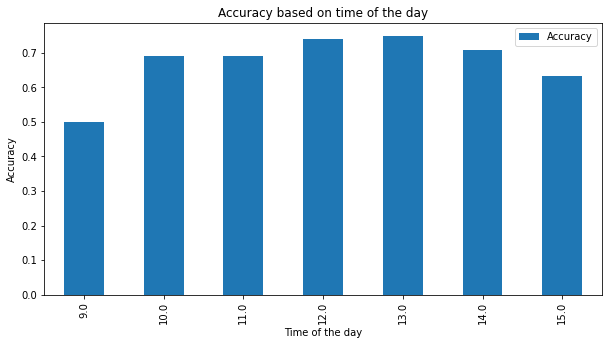

In [252]:
acc_df = result.groupby('Hour').apply(extract_accuracy)
acc_df.plot(x='Hour', y='Accuracy', kind='bar', figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("Accuracy")
plt.title("Accuracy based on time of the day")
plt.show()

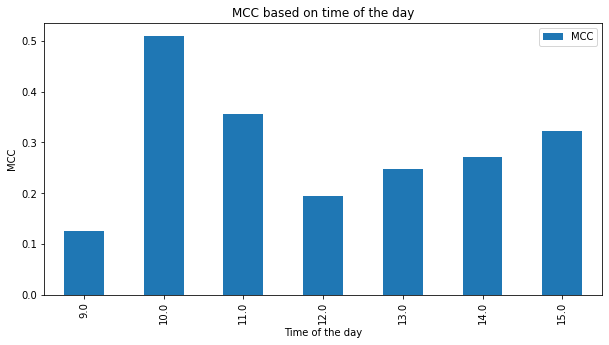

In [253]:
mcc_df = result.groupby('Hour').apply(extract_mcc)
mcc_df.plot(x='Hour', y='MCC', kind='bar', figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("MCC")
plt.title("MCC based on time of the day")
plt.show()

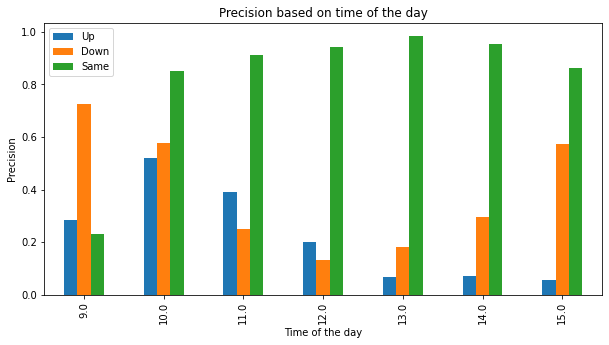

In [254]:
pre_df = result.groupby('Hour').apply(extract_metric(precision_score))
pre_df.plot(x='Hour', y=['Up', 'Down', 'Same'], kind='bar', figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("Precision")
plt.title("Precision based on time of the day")
plt.show()

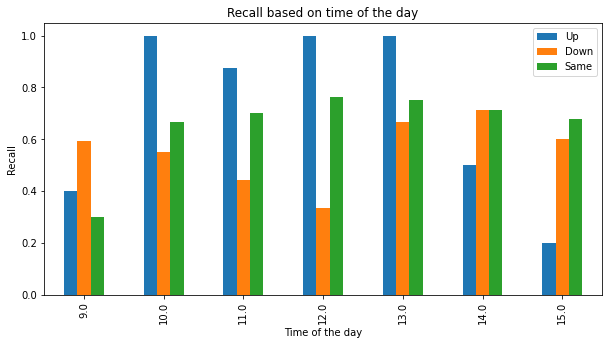

In [255]:
rec_df = result.groupby('Hour').apply(extract_metric(recall_score))
rec_df.plot(x='Hour', y=['Up', 'Down', 'Same'], kind='bar', figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("Recall")
plt.title("Recall based on time of the day")
plt.show()

In [261]:
ticker = 'GOOG'
START_DATE = '2022-10-1'
END_DATE = '2022-11-3'
FIG_SIZE = (10,5)
result = evaluate_on_ticker(transformer_model, ticker, START_DATE, END_DATE, conf_thresholds=[0,0.7,0.9])

result['Hour'] = result['Time'].apply(lambda timestamp: timestamp.hour)

def extract_accuracy(df):
    acc_df = pd.DataFrame(columns=['Hour', 'Accuracy'])
    acc_score = accuracy_score(df['Actual'], df['Prediction'])
    timestamp = df['Hour'].iloc[0]
    acc_df.loc[0] = [timestamp, acc_score] 
    return acc_df

def extract_mcc(df):
    acc_df = pd.DataFrame(columns=['Hour', 'MCC'])
    acc_score = matthews_corrcoef(df['Actual'], df['Prediction'])
    timestamp = df['Hour'].iloc[0]
    acc_df.loc[0] = [timestamp, acc_score] 
    return acc_df

def extract_metric(metric):
    def fit_df(df):
        metric_df = pd.DataFrame(columns=['Hour', 'Down', 'Up', 'Same'])
        metric_score = metric(df['Actual'], df['Prediction'], average=None)
        metric_df.loc[0] = [int(df['Hour'].iloc[0])] + [metric_score[i] for i in range(3)]
        return metric_df
    return fit_df

56/56 [==============================] - 1s 10ms/step
For predictions with confidence >= 0%, accuracy = 0.69
	 - 1765/1765 (100.00%) of all predictions
	 - 245/1765 (13.88%) of which have labels of val 0 (down)
	 - 115/1765 (6.52%) of which have labels of val 1 (up)
	 - 1405/1765 (79.60%) of which have labels of val 2 (same)
Performance:
              precision    recall  f1-score   support

        Down       0.62      0.44      0.51       345
          Up       0.72      0.24      0.36       348
Approx. Same       0.70      0.91      0.79      1072

    accuracy                           0.69      1765
   macro avg       0.68      0.53      0.55      1765
weighted avg       0.69      0.69      0.65      1765

56/56 [==============================] - 0s 5ms/step
For predictions with confidence >= 70.0%, accuracy = 0.77
	 - 1125/1765 (63.74%) of all predictions
	 - 93/1125 (8.27%) of which have labels of val 0 (down)
	 - 56/1125 (4.98%) of which have labels of val 1 (up)
	 - 976/1125 (

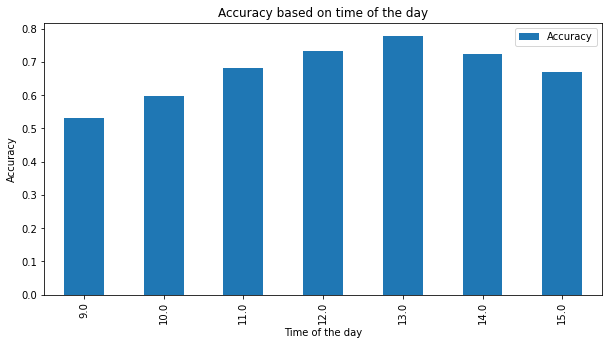

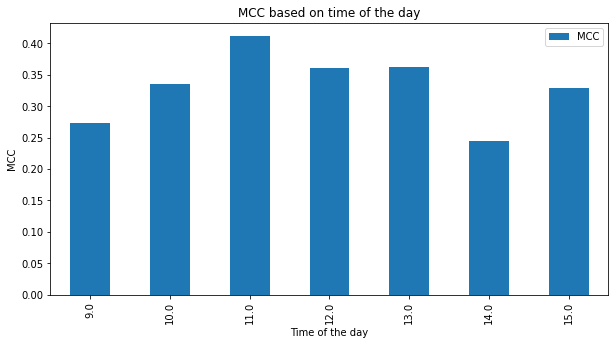

In [262]:
acc_df = result.groupby('Hour').apply(extract_accuracy)
acc_df.plot(x='Hour', y='Accuracy', kind='bar', figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("Accuracy")
plt.title("Accuracy based on time of the day")
plt.show()


mcc_df = result.groupby('Hour').apply(extract_mcc)
mcc_df.plot(x='Hour', y='MCC', kind='bar', figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("MCC")
plt.title("MCC based on time of the day")
plt.show()

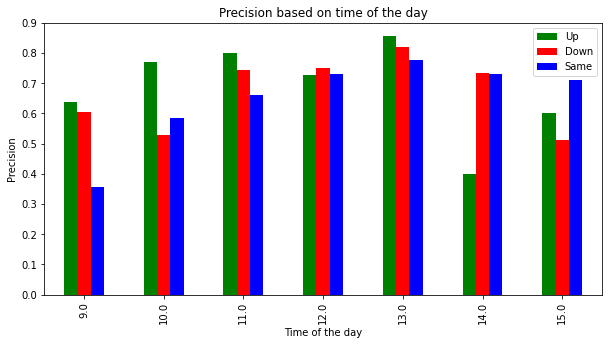

In [263]:


pre_df = result.groupby('Hour').apply(extract_metric(precision_score))
pre_df.plot(x='Hour', y=['Up', 'Down', 'Same'], kind='bar', color=['g','r','b'], figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("Precision")
plt.title("Precision based on time of the day")
plt.show()



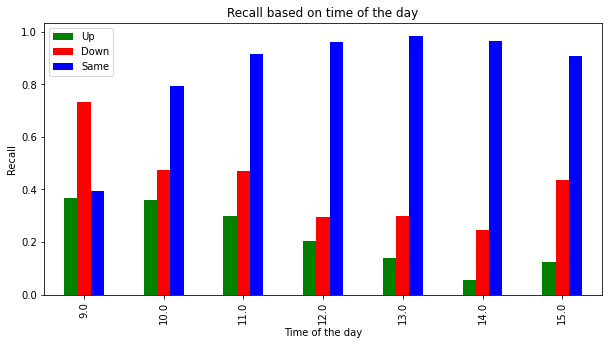

In [264]:


rec_df = result.groupby('Hour').apply(extract_metric(recall_score))
rec_df.plot(x='Hour', y=['Up', 'Down', 'Same'], kind='bar', color=['g','r','b'], figsize=(10,5))
plt.xlabel("Time of the day")
plt.ylabel("Recall")
plt.title("Recall based on time of the day")
plt.show()



In [269]:
up, down, same = np.bincount(np.hstack((y_train_single, y_test_single)))

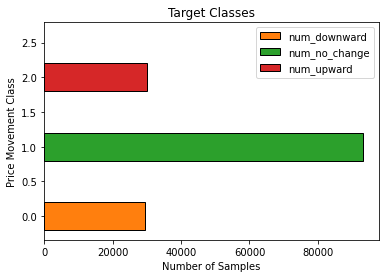

In [274]:
plt.barh([2.25], [0]) # expand to fit the legend
plt.barh([0], [down], height=0.4, edgecolor='k', label='num_downward')
plt.barh([1], [same], height=0.4, edgecolor='k', label='num_no_change')
plt.barh([2], [up], height=0.4, edgecolor='k', label='num_upward')
plt.title('Target Classes')
plt.xlabel('Number of Samples')
plt.ylabel('Price Movement Class')
plt.legend();
